# Inpainting de paisajes con autoencoders (Avance)

## Importaciones

In [11]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers

from google.colab import files
from google.colab import drive
from huggingface_hub import hf_hub_download

#drive.mount('/content/drive')
!git clone "https://github.com/LaucoTec/Inpainting_TC3007C.git"

Cloning into 'Inpainting_TC3007C'...
remote: Enumerating objects: 23497, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 23497 (delta 2), reused 0 (delta 0), pack-reused 23488 (from 1)
Receiving objects: 100% (23497/23497), 482.39 MiB | 18.55 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (24002/24002), done.


## Primer intento: Simple reconstrucción

### Cargar datasets

In [12]:
trainFolder = '/content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Training Data/Mountain'
valFolder = '/content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Validation Data/Mountain'
imgSize = (290, 174) # Tamaño original de las imágenes
batchSize = 32 # Tamaño de bloques

trainDS = tf.keras.utils.image_dataset_from_directory(
    trainFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

valDS = tf.keras.utils.image_dataset_from_directory(
    valFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

print(f"Dataset de entrenamiento cargado desde {trainFolder}")
print(f"Dataset de validación cargado desde {valFolder}")

Found 2000 files.
Found 300 files.
Dataset de entrenamiento cargado desde /content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Training Data/Mountain
Dataset de validación cargado desde /content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Validation Data/Mountain


Cargar únicamente conjuntos para entrenar y validar. no hay intención de seguir trabajando sobre esta pequeña iteración para probar más a detalle con un set dedicado de prueba.

La propia imagen es el objetivo, por lo que no se extraen etiquetas. Se separa por batches de 32 imágenes con mezclado aleatorio para que no se memorice el orden de los datos originales.

### Preprocesamiento

In [3]:
# Preprocesamiento a imágenes
def trainPre(image):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    return image, image

def valPre(image):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    return image, image


# Preprocesamiento a datasets
trainDS = (
    trainDS
    .shuffle(1000)
    .map(trainPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

valDS = (
    valDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


print(f"Nuevos detalles de entrenamiento: {trainDS.element_spec}")
print(f"Nuevos detalles de validación: {valDS.element_spec}")

Nuevos detalles de entrenamiento: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))
Nuevos detalles de validación: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))


En el preprocesado se normalizan todas las imágenes para valores de entre 0 y 1 para facilitar la convergencia, se activa un barajeo de mil imágenes para que en las épocas no se memorice un orden fijo ahora de los datos en el set cargado. Cache y prefetch permiten cargar todo en memoria aprovechando que aún son pocos datos para apurar el entrenamiento. Las imágenes se reducen a un 128x128 pues no se ocupa tanta información para la única clase que debe aprender.

Finalmente, el único aumento de datos aplicado es una inversión horizontal de las imágenes.  

### Construir el modelo

In [4]:
# Profundidad de 3
encoder = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(16, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(1024, activation='linear')
])

decoder = keras.Sequential([
    layers.Input(shape=(1024,)),

    layers.Dense(16 * 16 * 64, activation='relu'),
    layers.Reshape((16, 16, 64)),

    layers.UpSampling2D(size=2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.UpSampling2D(size=2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.UpSampling2D(size=2),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])


La arquitectura es sencilla con una profundidad de 3 antes del cuello de botella:
- Convoluciones con 2 de padding para reducir el tamaño y filtros de 16 hasta 64 para algo ligero.
  - ReLu se usa como función de activación aprovechando el recorte de 0 a 1 y evitar el desvanecimiento de gradiente.
- La regularización se hace por bloques al tener un tamaño de batch no tan pequeño, tras cada convolución.
- El cuello de botella final es una capa densa de 1024 neuronas de activación lineal.
- El decodificador, con la operación opuesta, realiza el upsampling antes de las convoluciones.
- La salida final es con una convolución de 3 filtros y kernel de 3.
  - Su activación es sigmoide ya que los valores originales se encontraban ya entre 0 y 1.

In [5]:
# Definir la entrada
input_img = keras.Input(shape=(128, 128, 3))

# Generar el encoder
encoded = encoder(input_img)

# Generar el decoder
decoded = decoder(encoded)

# Unir las partes
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1024)           │    16,802,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │    16,854,499 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,656,771 (128.39 MB)

 Trainable params: 33,656,323 (128.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# Generar modelo final
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError()
)

# Definir callbacks durante entrenamiento
# Early Stop
early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Checkpoints
ckptPath = "/content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=ckptPath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

Adam se usa como optimizador frecuentemente gracias a que puede ajustar la tasa de aprendizaje y corregir sesgos mientras mantiene un gran desempeño. La tasa original de 0.001 es de igual forma un valor frecuente.

Se definen dos callbacks:
- EarlyStopping para prevenir sobreajuste cuando la pérdida del set de validación ya no mejore o empeore.
- Checkpoint para guardar la mejor versión del modelo siempre.

In [7]:
history = autoencoder.fit(
    trainDS,
    epochs=50,
    validation_data=valDS,
    callbacks=[early, ckpt]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0518
Epoch 1: val_loss improved from inf to 0.05545, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - loss: 0.0515 - val_loss: 0.0554
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0219
Epoch 2: val_loss improved from 0.05545 to 0.04351, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - loss: 0.0218 - val_loss: 0.0435
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0175
Epoch 3: val_loss improved from 0.04351 to 0.03795, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - loss: 0.0175 - val_loss: 0.0379
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0156
Epoch 4: val_loss improved from 0.03795 to 0.02991, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - loss: 0.0156 - val_loss: 0.0299
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0147
Epoch 5: val_loss improved from 0.02991 to 0.02040, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - loss: 0.0147 - val_loss: 0.0204
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0134
Epoch 6: val_loss improved from 0.02040 to 0.01698, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - loss: 0.0134 - val_loss: 0.0170
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0128
Epoch 7: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - loss: 0.0128 - val_loss: 0.0176
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0121
Epoch 8: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - loss: 0.0121 - val_loss: 0.0182
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0115
Epoch 9: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - loss: 0.0115 - val_loss: 0.0193
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0112
Epoch 10: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - loss: 0.0112 - val_loss: 0.0247
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0110
Epoch 11: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - loss: 0.0110 - val_loss: 0.02

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


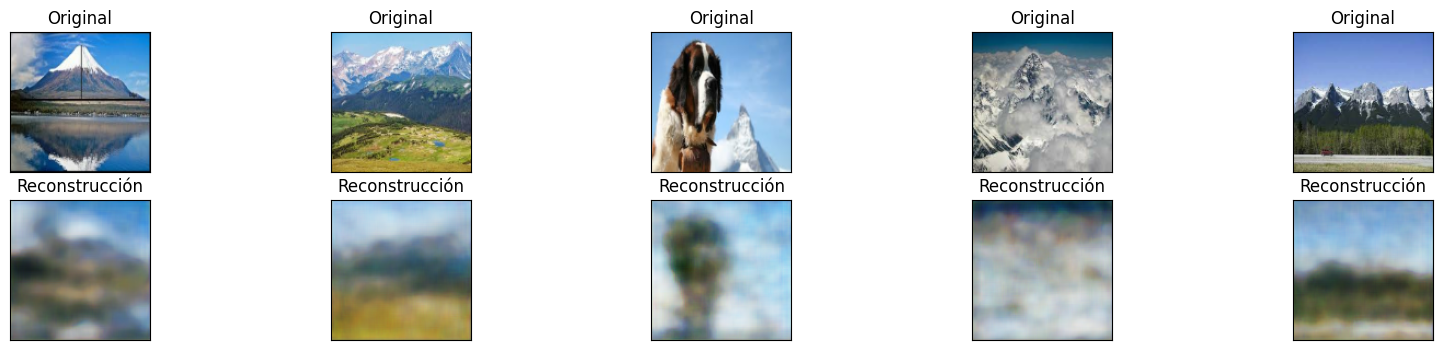

In [9]:
n = 5 # 5 ejemplos
plt.figure(figsize=(20, 4))

# Obtener un batch del set de validación
for x, _ in valDS.take(1):
    imgs = x.numpy()
    decoded_imgs = autoencoder.predict(imgs)

for i in range(n):
    # Mostrar orignal
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostrar reconstruido
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstrucción")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Naturalmente, los resultados son borrosos por ser una versión muy simple y limitada. Sin embargo, la silueta general de las imágenes se puede mantener tras la compresión. Algo a notar que artefactos externos al paisaje se intentan reinterpretar con la información aprendida, como se puede ver en la imagen con un perro que fue convertido en una montaña.

## Segundo intento: Denoiser con 2 clases

### Cargar datos

In [3]:
trainFolder = '/content/drive/MyDrive/Colab Notebooks/Inpainting/Train Data'
valFolder = '/content/drive/MyDrive/Colab Notebooks/Inpainting/Validate Data'
testFolder = '/content/drive/MyDrive/Colab Notebooks/Inpainting/Test Data'
imgSize = (290, 174) # Tamaño original
batchSize = 32

trainDS = tf.keras.utils.image_dataset_from_directory(
    trainFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

valDS = tf.keras.utils.image_dataset_from_directory(
    valFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

testDS = tf.keras.utils.image_dataset_from_directory(
    testFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

print(f"Dataset de entrenamiento cargado desde {trainFolder}")
print(f"Dataset de validación cargado desde {valFolder}")
print(f"Dataset de prueba cargado desde {testFolder}")

Found 4000 files.
Found 600 files.
Found 200 files.
Dataset de entrenamiento cargado desde /content/drive/MyDrive/Colab Notebooks/Inpainting/Train Data
Dataset de validación cargado desde /content/drive/MyDrive/Colab Notebooks/Inpainting/Validate Data
Dataset de prueba cargado desde /content/drive/MyDrive/Colab Notebooks/Inpainting/Test Data


shuffle ahora permite evitar el orden predeterminado de las clases al estar separadas por carpetas. Ahora sí se carga un conjunto específico para probar el modelo entrenado.

### Preprocesar

Nuevos detalles de entrenamiento: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None))
Nuevos detalles de validación: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None))
Nuevos detalles de prueba: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None))


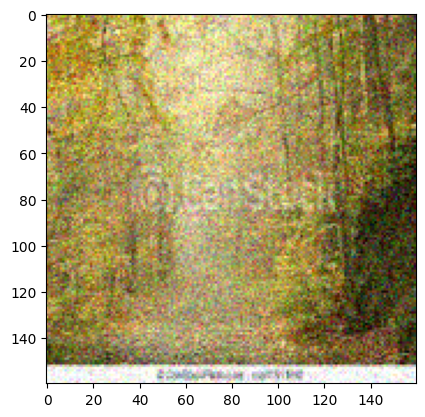

In [4]:
# Preprocesamiento a imágenes
def trainPre(image):
    image = tf.image.resize(image, (160, 160))
    clean = tf.cast(image, tf.float32) / 255.0

    clean = tf.image.random_flip_left_right(clean)
    noisy = clean + tf.random.normal(tf.shape(clean), stddev=0.1)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0)

    return noisy, clean

def valPre(image):
    image = tf.image.resize(image, (160, 160))
    image = tf.cast(image, tf.float32) / 255.0
    return image, image


# Preprocesamiento a datasets
trainDS = (
    trainDS
    .shuffle(1000)
    .map(trainPre, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

valDS = (
    valDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

testDS = (
    testDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


print(f"Nuevos detalles de entrenamiento: {trainDS.element_spec}")
print(f"Nuevos detalles de validación: {valDS.element_spec}")
print(f"Nuevos detalles de prueba: {testDS.element_spec}")

for img, _ in trainDS.take(1):
  img = img[1].numpy()
  plt.imshow(img)
  break

Al ser más imágenes en entrenamiento, ya no se les realiza el cache, así también el aumento de datos se realiza dinámicamente con cada iteración. Ahora se añade ruido gaussiano al entrenamiento y se deja un tamaño de imagen mayor para poder tener más información de donde extraer.

### Construir el modelo

In [5]:
encoder = keras.Sequential([
    layers.Input(shape=(160, 160, 3)),
    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(2048, activation='linear')
])

decoder = keras.Sequential([
    layers.Input(shape=(2048,)),

    layers.Dense(20 * 20 * 128, activation='relu'),
    layers.Reshape((20, 20, 128)),

    layers.UpSampling2D(size=2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.UpSampling2D(size=2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.UpSampling2D(size=2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])

In [6]:
# Definir la entrada
input_img = keras.Input(shape=(160, 160, 3))

# Generar el encoder
encoded = encoder(input_img)

# Generar el decoder
decoded = decoder(encoded)

# Construir el modelo, como funciones
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 2048)           │   104,953,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │   105,150,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,104,195 (801.48 MB)

 Trainable params: 210,103,299 (801.48 MB)

 Non-trainable params: 896 (3.50 KB)

La aquitectura es la misma que el básico, solamente se duplicaron los parámetros en general y se ajustaron al nuevo tamaño de  imagen.

In [7]:
# Generar modelo final
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError()
)

# Definir callbacks durante entrenamiento
# Early Stop
early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Checkpoints
ckptPath = "/content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=ckptPath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [8]:
history = autoencoder.fit(
    trainDS,
    epochs=50,
    validation_data=valDS,
    callbacks=[early, ckpt]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0470
Epoch 1: val_loss improved from inf to 0.05825, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 397ms/step - loss: 0.0469 - val_loss: 0.0583
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0226
Epoch 2: val_loss improved from 0.05825 to 0.03077, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 832ms/step - loss: 0.0226 - val_loss: 0.0308
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0187
Epoch 3: val_loss improved from 0.03077 to 0.02269, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 919ms/step - loss: 0.0187 - val_loss: 0.0227
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0167
Epoch 4: val_loss improved from 0.02269 to 0.01788, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 830ms/step - loss: 0.0167 - val_loss: 0.0179
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0153
Epoch 5: val_loss improved from 0.01788 to 0.01547, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 753ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0141
Epoch 6: val_loss did not improve from 0.01547
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - loss: 0.0141 - val_loss: 0.0162
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0138
Epoch 7: val_loss improved from 0.01547 to 0.01490, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - loss: 0.0138 - val_loss: 0.0149
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0127
Epoch 8: val_loss improved from 0.01490 to 0.01355, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - loss: 0.0127 - val_loss: 0.0135
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0126
Epoch 9: val_loss did not improve from 0.01355
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - loss: 0.0126 - val_loss: 0.0140
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0116
Epoch 10: val_loss did not improve from 0.01355
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 143ms/step - loss: 0.0116 - val_loss: 0.0211
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0118
Epoch 11: val_loss improved from 0.01355 to 0.01320, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - loss: 0.0118 - val_loss: 0.0132
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0110
Epoch 12: val_loss improved from 0.01320 to 0.01265, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 205s 905ms/step - loss: 0.0110 - val_loss: 0.0126
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0105
Epoch 13: val_loss improved from 0.01265 to 0.01209, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - loss: 0.0105 - val_loss: 0.0121
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0104
Epoch 14: val_loss did not improve from 0.01209
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 144ms/step - loss: 0.0104 - val_loss: 0.0129
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0103
Epoch 15: val_loss did not improve from 0.01209
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 134ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0097
Epoch 16: val_loss improved from 0.01209 to 0.01103, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - loss: 0.0097 - val_loss: 0.0110
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0092
Epoch 17: val_loss improved from 0.01103 to 0.01032, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - loss: 0.0092 - val_loss: 0.0103
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0092
Epoch 18: val_loss did not improve from 0.01032
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - loss: 0.0092 - val_loss: 0.0104
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0090
Epoch 19: val_loss did not improve from 0.01032
125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 141ms/step - loss: 0.0090 - val_loss: 0.0136
Epoch 20/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0098
Epoch 20: val_loss did not improve from 0.01032
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 21/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0089
Epoch 21: val_loss improved from 0.01032 to 0.01012, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - loss: 0.0089 - val_loss: 0.0101
Epoch 22/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0086
Epoch 22: val_loss improved from 0.01012 to 0.00988, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 0.0086 - val_loss: 0.0099
Epoch 23/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0084
Epoch 23: val_loss did not improve from 0.00988
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 139ms/step - loss: 0.0084 - val_loss: 0.0112
Epoch 24/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0083
Epoch 24: val_loss improved from 0.00988 to 0.00971, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - loss: 0.0083 - val_loss: 0.0097
Epoch 25/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0081
Epoch 25: val_loss did not improve from 0.00971
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 140ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 26/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0077
Epoch 26: val_loss improved from 0.00971 to 0.00958, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - loss: 0.0077 - val_loss: 0.0096
Epoch 27/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0078
Epoch 27: val_loss improved from 0.00958 to 0.00952, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - loss: 0.0078 - val_loss: 0.0095
Epoch 28/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0077
Epoch 28: val_loss improved from 0.00952 to 0.00925, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - loss: 0.0077 - val_loss: 0.0093
Epoch 29/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0073
Epoch 29: val_loss did not improve from 0.00925
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 141ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 30/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0074
Epoch 30: val_loss did not improve from 0.00925
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - loss: 0.0074 - val_loss: 0.0096
Epoch 31/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0074
Epoch 31: val_loss did not improve from 0.00925
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - loss: 0.0074 - val_loss: 0.0099
Epoch 32/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0071
Epoch 32: val_loss did not improve from 0.00925
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - loss: 0.0071 - val_loss: 0.0093
Epoch 33/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0071
Epoch 33: val_loss improved from 0.00925 to 0.00905, saving model to 

125/125 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - loss: 0.0071 - val_loss: 0.0091
Epoch 34/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0069
Epoch 34: val_loss improved from 0.00905 to 0.00895, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - loss: 0.0069 - val_loss: 0.0089
Epoch 35/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0069
Epoch 35: val_loss did not improve from 0.00895
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 143ms/step - loss: 0.0069 - val_loss: 0.0090
Epoch 36/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0067
Epoch 36: val_loss improved from 0.00895 to 0.00893, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - loss: 0.0067 - val_loss: 0.0089
Epoch 37/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0065
Epoch 37: val_loss did not improve from 0.00893
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 145ms/step - loss: 0.0065 - val_loss: 0.0100
Epoch 38/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0069
Epoch 38: val_loss did not improve from 0.00893
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 39/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0064
Epoch 39: val_loss did not improve from 0.00893
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - loss: 0.0064 - val_loss: 0.0102
Epoch 40/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0064
Epoch 40: val_loss improved from 0.00893 to 0.00878, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - loss: 0.0064 - val_loss: 0.0088
Epoch 41/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0066
Epoch 41: val_loss did not improve from 0.00878
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - loss: 0.0066 - val_loss: 0.0090
Epoch 42/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0066
Epoch 42: val_loss did not improve from 0.00878
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 143ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 43/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0069
Epoch 43: val_loss did not improve from 0.00878
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 44/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0064
Epoch 44: val_loss did not improve from 0.00878
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 45/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0061
Epoch 45: val_loss improved from 0.00878 to 0.00860, saving model to 

125/125 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.0061 - val_loss: 0.0086
Epoch 46/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0066
Epoch 46: val_loss did not improve from 0.00860
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 147ms/step - loss: 0.0066 - val_loss: 0.0105
Epoch 47/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0065
Epoch 47: val_loss did not improve from 0.00860
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 48/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0063
Epoch 48: val_loss improved from 0.00860 to 0.00850, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 0.0063 - val_loss: 0.0085
Epoch 49/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0058
Epoch 49: val_loss did not improve from 0.00850
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - loss: 0.0058 - val_loss: 0.0085
Epoch 50/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0058
Epoch 50: val_loss did not improve from 0.00850
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 140ms/step - loss: 0.0058 - val_loss: 0.0090


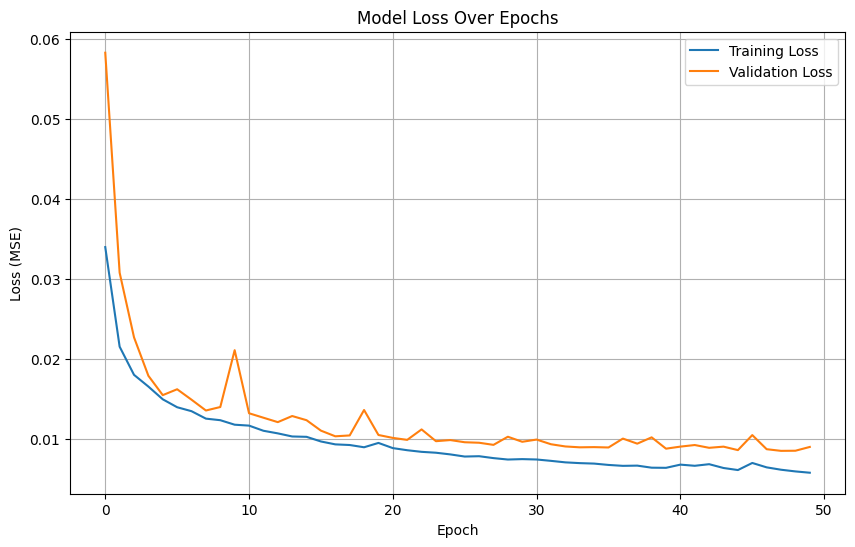

In [9]:
# Gráfica de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo a través de las épocas')
plt.ylabel('Loss (MSE)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()

Aunque ambas pérdidas son bastante bajas, no parece que lleguen a converger del todo en 50 épocas.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


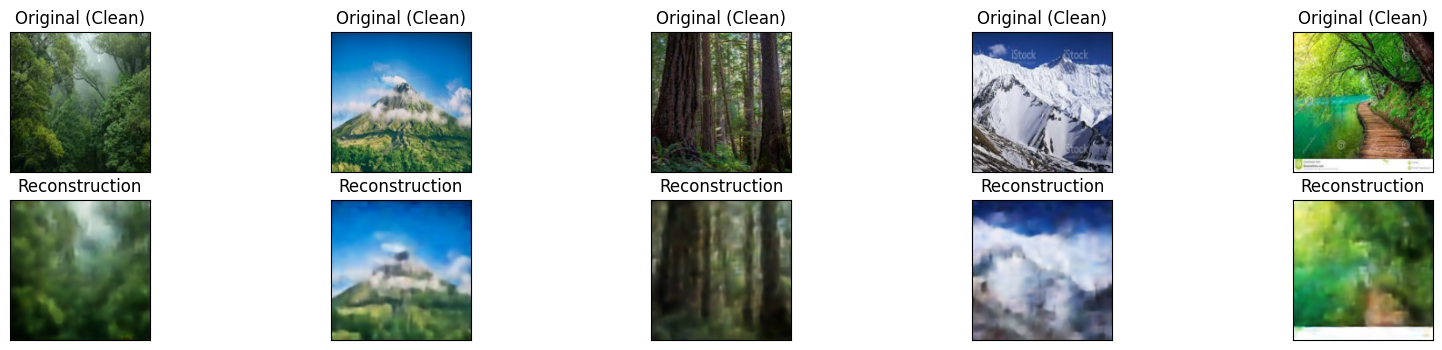

In [11]:
n = 5 # Mostrar 5 ejemplos
plt.figure(figsize=(20, 4))

# Obtener batch del set de prueba
for noisy_imgs, clean_imgs in testDS.take(1):
    original_imgs = clean_imgs.numpy() # Use clean images for 'original'
    decoded_imgs = autoencoder.predict(noisy_imgs) # Predict from noisy images

for i in range(n):
    # Imagen original y sin ruido
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstrucción")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Probar

In [8]:
# Cargar el modelo
repo = "LaucoTec/TC3007C_Inpainting"
modelPath = hf_hub_download(
    repo_id=repo,
    filename="models/DenoiserAE/dn_best.h5"
    )

denoiser = tf.keras.models.load_model(modelPath)

print(f"Cargado modelo de Denoiser desde: {modelPath}")
denoiser.summary()

models/DenoiserAE/dn_best.h5:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

Cargado modelo de Denoiser desde: /root/.cache/huggingface/hub/models--LaucoTec--TC3007C_Inpainting/snapshots/549557c9c20c2bb9f8b5c469a031c067858b74fc/models/DenoiserAE/dn_best.h5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 2048)           │   104,953,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │   105,150,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,104,197 (801.48 MB)

 Trainable params: 210,103,299 (801.48 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

In [15]:
# Subir la imagen a probar
uploaded = files.upload()

img_data = uploaded[list(uploaded.keys())[0]]
img = tf.image.decode_image(img_data, channels=3)
img = tf.image.resize(img, (160, 160))
img = tf.cast(img, tf.float32) / 255.0
input = np.expand_dims(img, axis=0)

print("Imagen cargada y preprocesada.")

Saving Forest-Test (84).jpeg to Forest-Test (84).jpeg
Imagen cargada y preprocesada.


**De momento sólo funciona con bosques o montañas.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


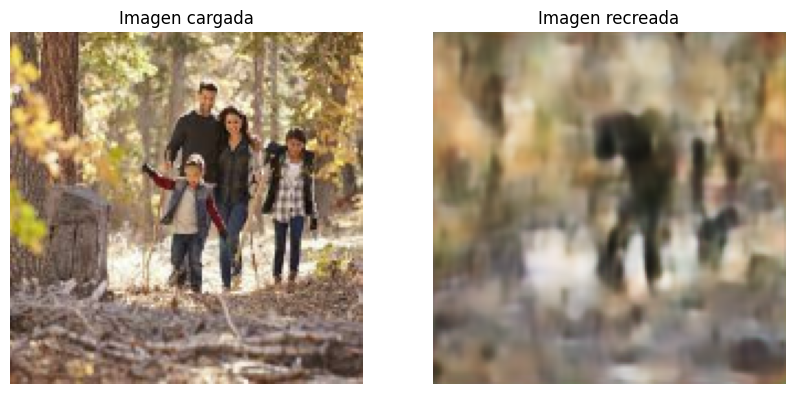

In [16]:
if 'input' in locals():
    # Usar el modelo
    denoised = denoiser.predict(input)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(input[0])
    plt.title("Imagen cargada")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised[0])
    plt.title("Imagen recreada")
    plt.axis('off')

    plt.show()
else:
    print("No se subió una imagen.")